# Notebook de referência 

Nome: Matheus Lindino

In [1]:
!wget -nc http://files.fast.ai/data/aclImdb.tgz 
!tar -xzf aclImdb.tgz
!pip install transformers pytorch-lightning evaluate -q

File ‘aclImdb.tgz’ already there; not retrieving.



In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Instruções:

Treinar e medir a acurácia de um modelo BERT (ou variantes) para classificação binária usando o dataset do IMDB (20k/5k amostras de treino/validação).

Importante: 
- Deve-se implementar o próprio laço de treinamento.
- Implementar o acumulo de gradiente.

Dicas:
- BERT geralmente costuma aprender bem uma tarefa com poucas épocas (de 3 a 5 épocas). Se tiver demorando mais de 5 épocas para chegar em 80% de acurácia, ajuste os hiperparametros.

- Solução para erro de memória:
  - Usar bfloat16 permite quase dobrar o batch size

Opcional:
- Pode-se usar a função trainer da biblioteca Transformers/HuggingFace para verificar se seu laço de treinamento está correto. Note que ainda assim é obrigatório implementar o laço próprio.

- Usar pytorch lightning. Para entender como o pytorch lightning funciona, veja uma implementação simplificada no notebook `06_01_Treino_Validação_MNIST_Lightning_Lite.ipynb`

In [23]:
import copy
import torch
import random
import evaluate
import numpy as np
import pytorch_lightning as pl
import torch.nn.functional as F

from torch.optim import Adam
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments, logging, EarlyStoppingCallback, IntervalStrategy

logging.set_verbosity_error()

In [18]:
params = {
    'random_seed': 123,
    'bert_version': 'bert-base-uncased',
    'batch_size': 32,
    'learning_rate': 2e-5,
    'max_length': 300,
    'epochs': 20,
    'patience': 3,
    'min_delta': 0,
    'weight_decay': 0.01,
    'accum_iter': 10
}

In [5]:
random.seed(params['random_seed'])
np.random.seed(params['random_seed'])
torch.manual_seed(params['random_seed'])

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


## Dataset 

In [7]:
max_valid = 5000

def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos = load_texts('aclImdb/test/pos')
x_test_neg = load_texts('aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg
y_train = [True] * len(x_train_pos) + [False] * len(x_train_neg)
y_test = [True] * len(x_test_pos) + [False] * len(x_test_neg)

# Embaralhamos o treino para depois fazermos a divisão treino/valid.
c = list(zip(x_train, y_train))
random.shuffle(c)
x_train, y_train = zip(*c)

x_valid = x_train[-max_valid:]
y_valid = y_train[-max_valid:]
x_train = x_train[:-max_valid]
y_train = y_train[:-max_valid]

print(len(x_train), 'amostras de treino.')
print(len(x_valid), 'amostras de desenvolvimento.')
print(len(x_test), 'amostras de teste.')

print('3 primeiras amostras treino:')
for x, y in zip(x_train[:3], y_train[:3]):
    print(y, x[:100])

print('3 últimas amostras treino:')
for x, y in zip(x_train[-3:], y_train[-3:]):
    print(y, x[:100])

print('3 primeiras amostras validação:')
for x, y in zip(x_valid[:3], y_test[:3]):
    print(y, x[:100])

print('3 últimas amostras validação:')
for x, y in zip(x_valid[-3:], y_valid[-3:]):
    print(y, x[:100])

20000 amostras de treino.
5000 amostras de desenvolvimento.
25000 amostras de teste.
3 primeiras amostras treino:
False Elvis Presley plays a "half-breed" Native American ("Indian") who has to defend his reservation from
False Hobgoblins... what a concept. Rick Sloan was a master with this film. He had the brilliance to produ
True I have to start off by apologizing because I thought the first 75-80% of this film was hilarious. It
3 últimas amostras treino:
False To review this movie, I without any doubt would have to quote that memorable scene in Tarantino's "P
True Lensman is a rather lesser-known Anime gem from Toho and MK studios.It's loosely based on the novel,
True Since it has been some years since I reviewed this classic I have decided to go back and review it m
3 primeiras amostras validação:
True Now this show looks like most of the other shows of it's type from the mid-90's, but the only thing 
True I won't go into too much detail about the plot of this movie as other reviewe

### Tokenizer and Dataloader 

In [8]:
class IMDBDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data   = data
        self.labels = torch.Tensor(labels).long()
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        item = {key: value[index] for key, value in self.data.items()}
        item['labels'] = self.labels[index] 
        return item

In [9]:
tokenizer = BertTokenizerFast.from_pretrained(params['bert_version'], disable_tqdm=False)

## TOKENIZE
train_encodings = tokenizer(list(x_train), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
valid_encodings = tokenizer(list(x_valid), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
test_encodings  = tokenizer(list(x_test), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])

## DATASET
train_dataset = IMDBDataset(data=train_encodings, labels=y_train)
valid_dataset = IMDBDataset(data=valid_encodings, labels=y_valid)
test_dataset  = IMDBDataset(data=test_encodings, labels=y_test)

## DATALOADER
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=8)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=params['batch_size'], num_workers=8)
test_loader  = DataLoader(dataset=test_dataset, batch_size=params['batch_size'], num_workers=8)

## Model

### Early Stopping

In [10]:
class EarlyStopping():
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.best_model_wts = None
        self.min_delta = min_delta

    def __call__(self, model, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            return False

        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0
        return False

### Classical Training

In [11]:
def train_epoch(model, dataloader, optimizer):
    running_loss = 0.0
    running_corrects = 0

    model.train()
    for batch_idx, data in enumerate(dataloader):
        
        input_ids      = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels         = data['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0] / params['accum_iter'] 

        _, preds = torch.max(outputs[1], 1)
        
        loss.backward()

        if ((batch_idx + 1) % params['accum_iter'] == 0) or (batch_idx + 1 == len(dataloader)):
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels)

    return running_loss, running_corrects

def evaluate(model, dataloader):
    running_loss = 0.0
    running_corrects = 0

    model.eval()
    for data in dataloader:
        
        input_ids      = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels         = data['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            _, preds = torch.max(outputs[1], 1)

            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels)

    return running_loss, running_corrects

In [12]:
model = BertForSequenceClassification.from_pretrained(params['bert_version'])
model = model.to(device)

optimizer = Adam(model.parameters(), lr=params['learning_rate'])
early_stopping = EarlyStopping(patience=params['patience'], min_delta=params['min_delta'])

history = {'train_loss': [], 'val_loss': [], 'train_acc':[], 'val_acc':[], 'train_perplexity': [], 'val_perplexity' : []}

for epoch in tqdm(range(params['epochs']), desc='Training'):

    train_loss, train_correct = train_epoch(model=model, 
                                          dataloader=train_loader, 
                                          optimizer=optimizer)

    val_loss, val_correct  = evaluate(model=model, 
                                    dataloader=valid_loader)
    
    train_loss = train_loss / len(train_loader)
    train_acc = train_correct.cpu().item() / len(train_loader.sampler) * 100
    train_perplexity = np.exp(train_loss)

    val_loss = val_loss / len(valid_loader)
    val_acc = val_correct.cpu().item() / len(valid_loader.sampler) * 100
    val_perplexity = np.exp(val_loss)

    if early_stopping(model, val_loss): break
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_perplexity'].append(train_perplexity)
    
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_perplexity'].append(val_perplexity)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

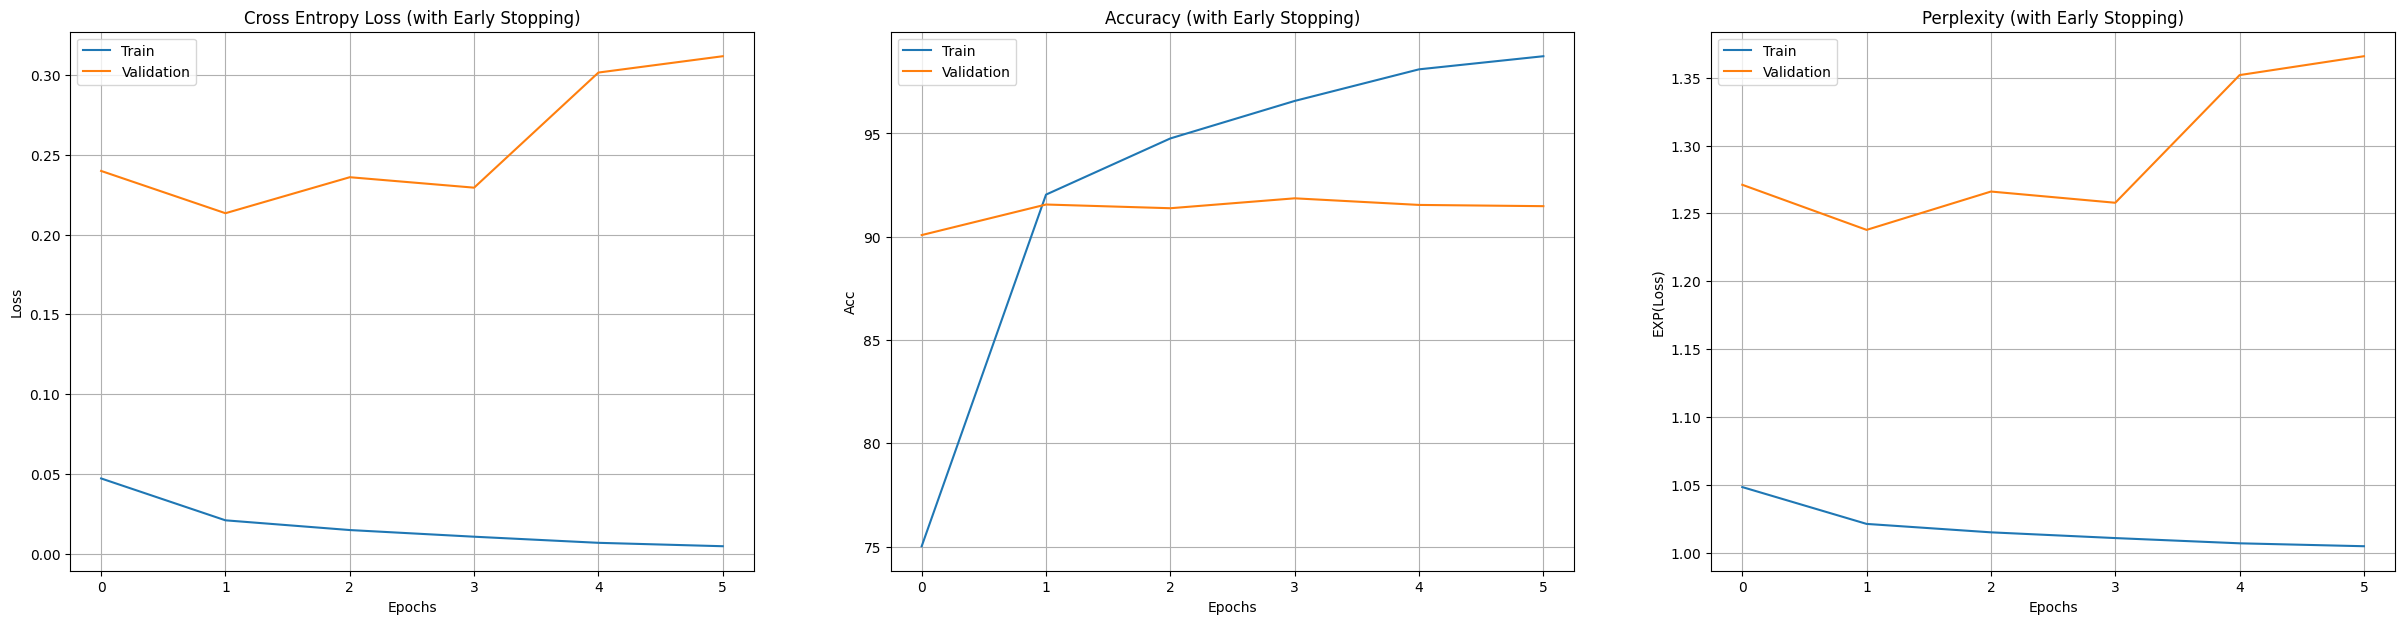

In [13]:
import matplotlib.pyplot as plt

epochs = np.arange(len(history['train_loss']))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,7))
axes[0].plot(epochs, history['train_loss'], label='Train')
axes[0].plot(epochs, history['val_loss'], label='Validation')
axes[0].set_title('Cross Entropy Loss (with Early Stopping)')
axes[0].set_xlabel('Epochs'); axes[0].set_ylabel('Loss')
axes[0].grid(); axes[0].legend()

axes[1].plot(epochs, history['train_acc'], label='Train')
axes[1].plot(epochs, history['val_acc'], label='Validation')
axes[1].set_title('Accuracy (with Early Stopping)')
axes[1].set_xlabel('Epochs'); axes[1].set_ylabel('Acc')
axes[1].grid(); axes[1].legend()

axes[2].plot(epochs, history['train_perplexity'], label='Train')
axes[2].plot(epochs, history['val_perplexity'], label='Validation')
axes[2].set_title('Perplexity (with Early Stopping)')
axes[2].set_xlabel('Epochs'); axes[2].set_ylabel('EXP(Loss)')
axes[2].grid(); axes[2].legend()

plt.show()

In [14]:
classicalLoop = BertForSequenceClassification.from_pretrained(params['bert_version'])
classicalLoop.load_state_dict(early_stopping.best_model_wts)
classicalLoop.to(device)

test_loss, test_correct  = evaluate(model=classicalLoop,
                                  dataloader=test_loader)

test_loss = test_loss / len(test_loader)
test_acc = test_correct.cpu().item() / len(test_loader.sampler) * 100
test_perplexity = np.exp(test_loss)

print(f'CLASSICAL LOOP --> TEST LOSS: {test_loss} ----- TEST ACC: {test_acc} ----- TEST PERPLEXITY: {test_perplexity}')

CLASSICAL LOOP --> TEST LOSS: 0.19733141157823755 ----- TEST ACC: 92.108 ----- TEST PERPLEXITY: 1.2181476820623431


In [15]:
del classicalLoop
del model

### Trainer (Hugging Face)

In [16]:
def compute_metrics(p):    
    preds, labels = p
    preds = np.argmax(preds, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=preds)
    return {"accuracy": accuracy}

In [21]:
args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy=IntervalStrategy.STEPS,
    eval_steps=50,
    save_total_limit=5,
    num_train_epochs=5,
    per_device_train_batch_size=params['batch_size'],
    per_device_eval_batch_size=params['batch_size'],
    weight_decay=params['weight_decay'],
    report_to='none',
    load_best_model_at_end=True,
    gradient_accumulation_steps=params['accum_iter'])

model_HF = BertForSequenceClassification.from_pretrained(params['bert_version'])
model_HF = model_HF.to(device)


trainer_HF = Trainer(
    model=model_HF,                         
    args=args,                  
    train_dataset=train_dataset,         
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=params['patience'])]
)

trainer_HF.train()

PyTorch: setting up devices
loading configuration file config.json from cache at /home/matheus.lindino/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /home/matheus.lindino/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e63

Step,Training Loss,Validation Loss,Accuracy
50,No log,0.231673,0.906400
100,No log,0.213682,0.920400
150,No log,0.245234,0.917400
200,No log,0.305596,0.917200
250,No log,0.283763,0.915400
300,No log,0.320472,0.913600


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=310, training_loss=0.14282240098522556, metrics={'train_runtime': 2552.3086, 'train_samples_per_second': 39.18, 'train_steps_per_second': 0.121, 'total_flos': 1.539199673856e+16, 'train_loss': 0.14282240098522556, 'epoch': 4.99})

In [24]:
predictions = trainer_HF.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
metric = evaluate.load("glue", "mrpc")
score = metric.compute(predictions=preds, references=predictions.label_ids)

print(f"CLASSICAL LOOP --> TEST ACC: {score['accuracy']*100}")

CLASSICAL LOOP --> TEST ACC: 92.10000000000001


In [25]:
del trainer_HF
del model_HF

### Pytorch Ligthing

In [27]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms

class PLModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = BertForSequenceClassification.from_pretrained(params['bert_version'])
        
    def forward(self, input_ids, attention_mask, labels):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return outputs

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=2e-5)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        input_ids      = train_batch['input_ids']
        attention_mask = train_batch['attention_mask']
        labels         = train_batch['labels']
        
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        
        _, preds = torch.max(outputs[1], 1)
        self.log('Training Loss', loss, on_epoch=True)
        return {'loss': loss, 'preds': preds, 'labels': labels}

    def validation_step(self, val_batch, batch_idx):
        input_ids      = val_batch['input_ids']
        attention_mask = val_batch['attention_mask']
        labels         = val_batch['labels']
        
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        _, preds = torch.max(outputs[1], 1)
        
        self.log('Valid Loss', loss, on_epoch=True)
        
        return {'loss': loss, 'preds': preds, 'labels': labels}
    
    def test_step(self, test_batch, batch_idx):
        input_ids      = test_batch['input_ids']
        attention_mask = test_batch['attention_mask']
        labels         = test_batch['labels']
        
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        _, preds = torch.max(outputs[1], 1)
        
        return {'loss': loss, 'preds': preds, 'labels': labels}
    
    def training_epoch_end(self, training_step_outputs):
        preds = torch.cat([data['preds'] for data in training_step_outputs])
        loss = torch.stack([data['loss'] for data in training_step_outputs])
        labels = torch.cat([data['labels'] for data in training_step_outputs])
        
        acc = torch.sum(preds == labels)
        self.log('Training Epoch Accuracy', acc/preds.shape[0])

    def validation_epoch_end(self, validation_step_outputs):
        preds = torch.cat([data['preds'] for data in validation_step_outputs])
        loss = torch.stack([data['loss'] for data in validation_step_outputs])
        labels = torch.cat([data['labels'] for data in validation_step_outputs])
        
        acc = torch.sum(preds == labels)
        self.log('Validation Epoch Accuracy', acc/preds.shape[0])

    def test_epoch_end(self, test_step_outputs):
        preds = torch.cat([data['preds'] for data in test_step_outputs])
        loss = torch.stack([data['loss'] for data in test_step_outputs])
        labels = torch.cat([data['labels'] for data in test_step_outputs])
        
        acc = torch.sum(preds == labels)
        self.log('Test Epoch Loss', loss.mean())
        self.log('Test Accuracy', acc/preds.shape[0])
        
model_PL = PLModel()
trainer_PL = pl.Trainer(max_epochs=5, accelerator='gpu', devices=1, accumulate_grad_batches=params['accum_iter'], callbacks=[EarlyStopping(monitor='Valid Loss', mode='min', patience=3)])
trainer_PL.fit(model_PL, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                          | Params
--------------------------------------------------------
0 | model | BertForSequenceClassification | 109 M 
--------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.935   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [28]:
score = trainer_PL.test(model_PL, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test Accuracy         0.9185999631881714
     Test Epoch Loss         0.242848739027977
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
